In [1]:
import pandas as pd
import numpy as np 

import geopandas as gpd
import shapely
import fiona
import folium

## Dataset

In [2]:
SHAPE_FOLDER = '/home/adelsondias/Repos/newcastle/air-quality/shape/Middle_Layer_Super_Output_Areas_December_2011_Full_Extent_Boundaries_in_England_and_Wales'
DATA_FOLDER = '/home/adelsondias/Repos/newcastle/air-quality/data_7days'

Importing output areas for spatial delimitation

In [3]:
lsoa = gpd.read_file(SHAPE_FOLDER+'/Middle_Layer_Super_Output_Areas_December_2011_Full_Extent_Boundaries_in_England_and_Wales.shp')
lsoa = lsoa[lsoa['msoa11nm'].str.contains('Newcastle upon Tyne')]
lsoa = lsoa.to_crs(fiona.crs.from_epsg(4326))
lsoa.crs = {'init': 'epsg:4326', 'no_defs': True}

lsoa.plot()

Parsing metadata positions to geopandas/shapely geometries and filtering them by output areas

In [4]:
metadata = pd.read_csv(DATA_FOLDER+'/sensors.csv')

# spatial parsing - geometry column
metadata = gpd.GeoDataFrame(metadata[['name','type','active','lon','lat']],
                        geometry=[shapely.geometry.Point(xy) for xy in zip(metadata['lon'], metadata['lat'])], 
                        crs={'init': 'epsg:4326'}).to_crs(fiona.crs.from_epsg(4326))

metadata = gpd.sjoin(metadata, lsoa, how='inner' ,op='intersects')[['name','type','active','lon','lat','geometry']]
metadata = metadata.set_index('name')

metadata.shape

(147, 5)

Resampling sensors samples to a specific time frequency, acquiring medians to avoid outliers, and also samples inside output area

In [5]:
sensors = pd.read_csv(DATA_FOLDER+'/data.csv')
sensors['Timestamp'] = pd.to_datetime(sensors['Timestamp'])
sensors = sensors.set_index(['Variable','Sensor Name','Timestamp'])

# resampling by freq
freq='H'
level_values = sensors.index.get_level_values
sensors = (sensors.groupby([level_values(i) for i in [0,1]]
                   +[pd.Grouper(freq=freq, level=-1)]).median())

# filtering by Newcastle's region
m = metadata.index.values
s = sensors.reset_index()
s = s.loc[s['Sensor Name'].isin(m)]
sensors = s.set_index(['Variable','Sensor Name','Timestamp'])

sensors.reset_index()['Sensor Name'].unique().shape

(147,)

Reducing metadata and sensors dataframes to consider less variables

In [6]:
variables = ['CO', 'Humidity', 'Journey Time', 'NO2', 'O3', 
             'PM10', 'Particle Count', 'Sound', 'Temperature', 
             'Wind Direction', 'Wind Speed']
# variables = ['NO2', 'O3', 'Temperature']

sensors = sensors.loc[variables]
metadata = metadata.loc[sensors.index.get_level_values(1).unique()]

## Feature ingestion

This consider a list of k neighbors measures for each time and variable, to predict a single target specified

In [7]:
def ingestion(sensors, metadata, variables, k, target):
    idx = pd.IndexSlice
    zi = sensors.loc[target]
    zx = pd.DataFrame()
    for s in sensors.index.get_level_values(1).unique():
        i = metadata.loc[s]
#         print('for sensor {}'.format(i.name))

        for t in sensors.index.get_level_values(2).unique():
    #         print('-- for timestamp {}'.format(t))
            zkj = pd.DataFrame()
            zk = pd.DataFrame()
            zk['timestamp'] = [t]*k
            zk['zi'] = [i.name]*k
            zk['Sensor Name'] = range(0,k)
            zk.set_index(['zi','timestamp','Sensor Name'],inplace=True)

            for var in variables:

                sdf = sensors.loc[idx[var,:,t],:] # sensors of the var variable at  time t 
                mdf = metadata.loc[sdf.index.get_level_values(1).unique()] # metadata about them

                dij = mdf['geometry'].apply(lambda x: i['geometry'].distance(x)).sort_values() # nearest measures for (var,t)
                dij = dij.loc[(dij.index!=i.name) & (dij>0)][:k] # excluding the sensor i

                zj = sdf.loc[idx[:,dij.index,:],:].reset_index([0,2])['Value']
                zj.name = var

                zj.index = range(0,k)
                dij.index = range(0,k)

                zk.loc[idx[i.name,t],'d_{}'.format(var)] = dij.values
                zk.loc[idx[i.name,t],var] = zj.values
                zkj = zk.melt().set_index('variable').T
                zkj.index = [t]
                zkj['zi'] = i.name
                zkj = zkj.reset_index().set_index(['zi','index'])
            zx = zx.append(zkj)
    zx['day'] = zx.index.get_level_values(1).day
    zx['hour'] = zx.index.get_level_values(1).hour
    zx['month'] = zx.index.get_level_values(1).month

    zx = zx.loc[zi.index]
    zi = zi.loc[idx[zx.index.get_level_values(0).unique(),zx.index.get_level_values(1).unique()],:]

    return zx, zi

In [8]:
zx, zi = ingestion(sensors, metadata, variables=['NO2','O3','Humidity'], k=3, target='NO2')
print(zx.shape)
print(zi.shape)
zx.head()

(9104, 21)
(9104, 1)


variable                               d_NO2     d_NO2     d_NO2        NO2  \
Sensor Name    Timestamp                                                      
aq_mesh1756150 2018-07-05 23:00:00  0.001582  0.001956  0.002386  31.668412   
               2018-07-06 00:00:00  0.001582  0.001956  0.002386  27.726898   
               2018-07-06 01:00:00  0.001582  0.001956  0.002386  21.640210   
               2018-07-06 02:00:00  0.001582  0.001956  0.002386  21.244846   
               2018-07-06 03:00:00  0.001582  0.001956  0.002386  18.590568   

variable                                  NO2        NO2      d_O3      d_O3  \
Sensor Name    Timestamp                                                       
aq_mesh1756150 2018-07-05 23:00:00  35.866126  36.969455  0.001956  0.003461   
               2018-07-06 00:00:00  34.111676  34.026074  0.001956  0.003461   
               2018-07-06 01:00:00  29.986847  31.501989  0.001956  0.003461   
               2018-07-06 02:00:00  30.622982  29.043784  0.001956  0.003461   
               2018-07-06 03:00:00  26.060055  23.775482  0.001956  0.003461   

variable                                d_O3         O3  ...           O3  \
Sensor Name    Timestamp                                 ...                
aq_mesh1756150 2018-07-05 23:00:00  0.003558  18.783574  ...    20.517627   
               2018-07-06 00:00:00  0.003558  18.835521  ...    23.245068   
               2018-07-06 01:00:00  0.003558  20.799724  ...    26.882009   
               2018-07-06 02:00:00  0.003558  19.539289  ...    24.730233   
               2018-07-06 03:00:00  0.003558  20.196611  ...    23.090234   

variable                            d_Humidity  d_Humidity  d_Humidity  \
Sensor Name    Timestamp                                                 
aq_mesh1756150 2018-07-05 23:00:00    0.001582    0.001956    0.002386   
               2018-07-06 00:00:00    0.001582    0.001956    0.002386   
               2018-07-06 01:00:00    0.001582    0.001956    0.002386   
               2018-07-06 02:00:00    0.001582    0.001956    0.002386   
               2018-07-06 03:00:00    0.001582    0.001956    0.002386   

variable                             Humidity  Humidity  Humidity  day  hour  \
Sensor Name    Timestamp                                                       
aq_mesh1756150 2018-07-05 23:00:00  72.400002      67.1      67.6    5    23   
               2018-07-06 00:00:00  73.150002      68.5      69.1    6     0   
               2018-07-06 01:00:00  73.850003      69.6      70.5    6     1   
               2018-07-06 02:00:00  74.599998      70.1      71.0    6     2   
               2018-07-06 03:00:00  74.500000      71.0      71.0    6     3   

variable                            month  
Sensor Name    Timestamp                   
aq_mesh1756150 2018-07-05 23:00:00      7  
               2018-07-06 00:00:00      7  
               2018-07-06 01:00:00      7  
               2018-07-06 02:00:00      7  
               2018-07-06 03:00:00      7  

[5 rows x 21 columns]

In [13]:
# zx.to_csv(DATA_FOLDER+'/zx_7days.csv')
# zi.to_csv(DATA_FOLDER+'/zi_7days.csv')

Value
Sensor Name       Timestamp                      
aq_mesh1756150    2018-07-05 23:00:00   49.174784
                  2018-07-06 00:00:00   40.032249
                  2018-07-06 01:00:00   33.657264
                  2018-07-06 02:00:00   33.606316
                  2018-07-06 03:00:00   31.453340
                  2018-07-06 04:00:00   34.752927
                  2018-07-06 05:00:00   37.267145
                  2018-07-06 06:00:00   35.931124
                  2018-07-06 07:00:00   35.117554
                  2018-07-06 08:00:00   30.947526
                  2018-07-06 09:00:00   29.755606
                  2018-07-06 10:00:00   32.305544
                  2018-07-06 11:00:00   33.760381
                  2018-07-06 12:00:00   29.858535
                  2018-07-06 13:00:00   29.008494
                  2018-07-06 14:00:00   25.428692
                  2018-07-06 15:00:00   48.571491
                  2018-07-06 16:00:00   86.641209
                  2018-07-06 17:00:00   86.587537
                  2018-07-06 18:00:00  100.560262
                  2018-07-06 19:00:00   71.141268
                  2018-07-06 20:00:00   75.419397
                  2018-07-06 21:00:00   74.415476
                  2018-07-06 22:00:00   80.193562
                  2018-07-06 23:00:00   79.514132
                  2018-07-07 00:00:00   55.369664
                  2018-07-07 01:00:00   41.783753
                  2018-07-07 02:00:00   46.405637
                  2018-07-07 03:00:00   54.020483
                  2018-07-07 04:00:00   52.736914
...                                           ...
new_new_emote_906 2018-07-11 17:00:00   17.554628
                  2018-07-11 18:00:00   34.139367
                  2018-07-11 19:00:00   38.502671
                  2018-07-11 20:00:00   44.243344
                  2018-07-11 21:00:00   40.586181
                  2018-07-11 22:00:00   42.561137
                  2018-07-11 23:00:00   34.556468
                  2018-07-12 00:00:00   33.852605
                  2018-07-12 01:00:00   33.953074
                  2018-07-12 02:00:00   29.328886
                  2018-07-12 03:00:00   30.867984
                  2018-07-12 04:00:00   27.409911
                  2018-07-12 05:00:00   23.630705
                  2018-07-12 06:00:00   33.506482
                  2018-07-12 07:00:00   35.035645
                  2018-07-12 08:00:00   30.251030
                  2018-07-12 09:00:00   28.335802
                  2018-07-12 10:00:00   34.498271
                  2018-07-12 11:00:00   29.273422
                  2018-07-12 12:00:00   23.188214
                  2018-07-12 13:00:00   26.266982
                  2018-07-12 14:00:00   23.961904
                  2018-07-12 15:00:00    8.870943
                  2018-07-12 16:00:00   19.944537
                  2018-07-12 17:00:00   19.995397
                  2018-07-12 18:00:00   17.562919
                  2018-07-12 19:00:00   35.028089
                  2018-07-12 20:00:00   41.794519
                  2018-07-12 21:00:00   45.311078
                  2018-07-12 22:00:00   42.842757

[9104 rows x 1 columns]

## Regression example

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()

paramsrf = {
    'n_estimators':np.arange(5,100,5),
    'max_features':np.arange(0.1, 1.01, 0.05),
    'max_depth':np.arange(1,10,1)
}
grid = RandomizedSearchCV(rf, param_distributions=paramsrf,
                    n_iter=500, scoring='r2', n_jobs=-1, cv=5).fit(zx.values, np.ravel(zi.values))
grid.best_score_

-0.14820038930663576

## Feature importance analysis

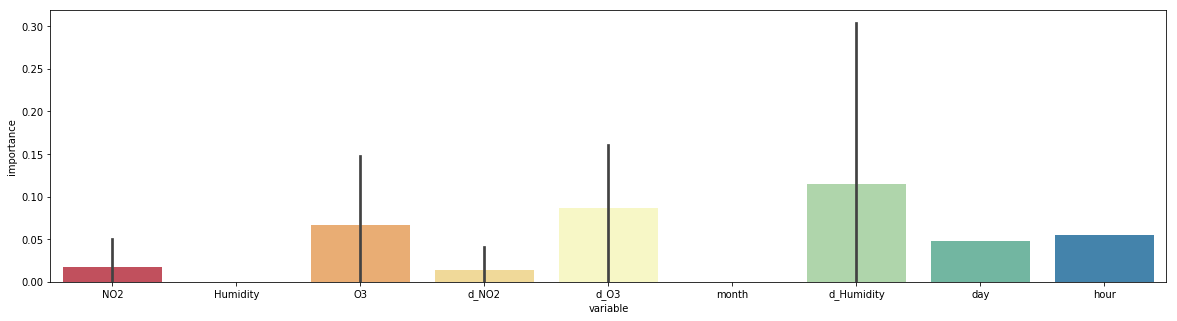

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

importances = grid.best_estimator_.feature_importances_
indices = zx.columns[np.argsort(importances)[::-1]]
f = pd.DataFrame(importances, index=indices, columns=['importance']).reset_index().sort_values('importance')

plt.figure(figsize=(20,5))
sns.barplot(x='variable',y='importance',data=f, palette='Spectral')